In [1]:
# Imports - these are all the imports needed for the assignment
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import nltk package 
#   PennTreeBank word tokenizer 
#   English language stopwords
import nltk
from nltk.tokenize import word_tokenize

import random

import seaborn as sns

from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_recall_fscore_support

In [2]:
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /home/q/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /home/q/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
from nltk.tokenize import word_tokenize

In [6]:
inspections_filepath = "inspections.csv"
inspections_df = pd.read_csv(inspections_filepath)

restaurants_filepath = "restaurants.csv"
restaurants_df = pd.read_csv(restaurants_filepath, dtype={
    "hsisid": str,
    "postal_code": str,
})

violations_filepath = "violations.csv"
violations_df = pd.read_csv(violations_filepath, dtype={
    "hsisid": str,
    "comments": str,
})

yelp_filepath = "yelp.csv"
yelp_df = pd.read_csv(yelp_filepath, dtype={
    "zip_code": str
})

#### Converters

In [8]:
def convert_restaurant_names(name_in):
        
    # Make the input all lowercase
    name_in = name_in.lower()
    
    # Drop all whitespace
    name_in = name_in.strip()
    
    # Chain restaurants have are of format 'chain name #NUMBER'
    # Remove '#NUMBER' is present
    hash_index = name_in.find('#')
    if hash_index != -1:
        name_in = name_in[0:hash_index]
        
    name_in = name_in.replace("i pre-security", "")
    name_in = name_in.replace("&amp;", "and")
    name_in = name_in.replace("&", "and")
        
    if "subway" in name_in:
        name_in = "subway"
    elif "mcdonald's" in name_in or "mcdonalds" in name_in:
        name_in = "mcdonald's"
    elif "starbuck" in name_in:
        name_in = "starbuck"
    elif "dunkin donuts" in name_in:
        name_in = "dunkin donuts"
    elif "arby's" in name_in:
        name_in = "arby's"
    elif "jersey mike" in name_in:
        name_in = "jersey mike"
    elif "wendy's" in name_in:
        name_in = "wendy's"
    elif "jamba j" in name_in:
        name_in = "jamba juice"
    elif "culver" in name_in:
        name_in = "culver's"
    elif "einstein" in name_in and "bagel" in name_in:
        name_in = "einstein bros bagel"
    elif "whataburger" in name_in:
        name_in = "whataburger"
    elif "church's chicken" in name_in:
        name_in = "church's hicken"
    elif "five guys" in name_in:
        name_in = "five guys"
    elif "chick-fil-a" in name_in:
        name_in = "chick-fil-a"
    elif "aubrey" in name_in and "peedi" in name_in and "grill" in name_in:
        name_in = "aubrey and peedies grill"
    elif "skipper's fish fry" in name_in or "skipper`s fish fry and market" == name_in:
        name_in = "skipper's fish fry"
    elif "dean's seafood grill" in name_in:
        name_in = "dean's seafood grill and bar"
    elif "salvio" in name_in and "pizzeria" in name_in:
        name_in = "salvio's pizzeria"
    elif "manchester" in name_in and "grill" in name_in:
        name_in = "manchester bar and grill"
    elif "sam" in name_in and "club" in name_in:
        name_in = "sam's club"
    elif "sami" in name_in and "pizza" in name_in and "more" in name_in:
        name_in = "sami's subs, pizza, and more"
        
    if name_in == "spring cafe 2":
        name_in = "spring cafe"
    
    return name_in.strip()

assert convert_restaurant_names("chick-fil-a #1573") == 'chick-fil-a'
assert convert_restaurant_names("taco bell #22798") == 'taco bell'
assert convert_restaurant_names("chick-fil-a of knightdale") == "chick-fil-a"

In [9]:
def convert_time(str_in):
    return pd.to_datetime(str_in)

In [10]:
def convert_zip(zipcode):
    
    # ZIP codes of form "AAAAA-BBBB" are specific version of "AAAAA"
    hyphen_index = zipcode.find('-')
    if hyphen_index != -1:
        zipcode = zipcode[0:hyphen_index]

    zipcode = zipcode.strip()
    return zipcode


assert convert_zip("12345") == "12345"
assert convert_zip("12345-678") == "12345"

In [11]:
restaurants_df_clean = restaurants_df.drop(labels=[
    "X.objectid",
    "name",
    "state",
    "address1",
    "address2",
    "city",
    "phonenumber",
    "geocodestatus",
    "x",
    "y",
    "facilitytype"
], axis="columns")

restaurants_df_clean.rename(columns={
    "hsisid": "id",
    "postalcode": 'zip',
    "restaurantopendate": "open_date"
}, inplace=True)

restaurants_df_clean = restaurants_df_clean[(restaurants_df["facilitytype"] == "Restaurant") 
                                            & (restaurants_df["facilitytype"] == "Restaurant")]
restaurants_df_clean["name"] = restaurants_df["name"].apply(convert_restaurant_names)
restaurants_df_clean["zip"] = restaurants_df_clean["zip"].apply(convert_zip)
restaurants_df_clean["open_date"] = restaurants_df_clean["open_date"].apply(convert_time)

restaurant_ids = restaurants_df_clean["id"]

restaurants_df_clean = restaurants_df_clean.reindex()
assert restaurants_df_clean["id"].is_unique == True

In [12]:
restaurants_df_clean.head()

,id,zip,open_date,name
0,4092017230,27616,2016-05-26 00:00:00+00:00,spring cafe
2,4092014444,27587,2005-12-05 00:00:00+00:00,taco bell
3,4092015333,27601,2009-02-04 00:00:00+00:00,the remedy diner
6,4092016679,27601,2014-04-23 00:00:00+00:00,bittersweet
7,4092014493,27617,2006-01-31 00:00:00+00:00,chick-fil-a


* **DATA IS FROM NORTH CAROLINA**
* Only care about restaurants ('facilitytype' in restaurants_df)
* Use 'hsisid' ('id') to ID locations and connect to violations
* Ignore address, name, phone number
* Yelp rating: 1-5 stars
* "Violations" with penalty = 0 are not actually violations but acknowledgements of good practice
* Many restaurants may be at same address
* Assuming yelp "rating" is the average across all reviews (treating it as a quantiative value), rounded to the nearest half
* Severity unknown meaning

In [13]:
violations_df_clean = violations_df.drop(labels=[
    "X.objectid",
    "statecode",
    "questionno",
    "violationcode",
    "inspectedby",
    "cdcriskfactor",
    "cdcdataitem",
    "violationtype",
    "observationtype",
    "count",
    "category",
    "shortdesc",
    "severity",
    "critical",
], axis="columns")
    
violations_df_clean.rename(columns={
    "hsisid": "id",
    "pointvalue": "penalty",
    "inspectdate": "inspect_date",
}, inplace=True)

violations_df_clean["inspect_date"] = violations_df_clean["inspect_date"].apply(convert_time)
violations_df_clean.drop_duplicates(inplace=True)
violations_df_clean = violations_df_clean.reindex()

In [14]:
violations_df_clean.head()

,id,inspect_date,comments,penalty
0,4092015279,2014-09-22 00:00:00+00:00,7-102.11; Priority Foundation - Found unlabele...,0
1,4092014572,2014-09-29 00:00:00+00:00,7-102.11; Priority Foundation; One sanitizer b...,0
2,4092015906,2014-10-01 00:00:00+00:00,7-102.11; Priority Foundation - Found an unlab...,1
3,4092013840,2014-10-08 00:00:00+00:00,7-102.11; Priority Foundation - Found unlabele...,0
4,4092021788,2014-10-09 00:00:00+00:00,7-102.11; Priority Foundation - Found one unla...,0


In [15]:
violations_df_clean["penalty"].value_counts()

0    130614
1     45019
2      4857
3      1020
4         6
Name: penalty, dtype: int64

In [16]:
violations_df_clean[violations_df_clean["penalty"] == 4]

,id,inspect_date,comments,penalty
57634,4092010071,2013-03-05 00:00:00+00:00,2-301.12 (C) TO avoid recontaminating their ha...,4
58414,4092012304,2012-12-06 00:00:00+00:00,P - 2-301.14 - Observed worker wash his hands ...,4
58478,4092013716,2013-02-21 00:00:00+00:00,2-301.14 An employee was observed scrubbing a...,4
67549,4092013070,2013-08-19 00:00:00+00:00,2-301.14; Priority; Employee working the gril...,4
69327,4092021677,2016-02-05 00:00:00+00:00,2-301.14; Priority; Employees must wash hands ...,4
162894,4092014362,2013-10-17 00:00:00+00:00,2-301.14; Priority; The cook handled raw chick...,4


In [17]:
yelp_df_clean = yelp_df.drop(labels=[
    "address1",
    "name",
    "price",
    "italian",
    "seafood",
    "newamerican",
    "chicken_wings",
    "delis",
    "bars",
    "salad",
    "seafood",
    "bbq",
    "bakeries",
    "sushi",
    "phone",
    "hotdogs",
    "sandwiches",
    "pizza",
    "tradamerican",
    "burgers",
    "mexican",
    "grocery",
    "breakfast_brunch",
    "coffee",
    "chinese",
    "latitude",
    "longitude",
    "price",
    "id",
    "is_closed",
], axis="columns")


yelp_df_clean.rename(columns={
    "id": "yelp_id",
    "zip_code": 'zip'
}, inplace=True)

yelp_df_clean["name"] = yelp_df["name"].apply(convert_restaurant_names)
yelp_df_clean["zip"] = yelp_df_clean["zip"].apply(convert_zip)

yelp_df_clean = yelp_df_clean[["zip", "name", "rating", "review_count"]]

In [18]:
yelp_df_clean.head()

,zip,name,rating,review_count
0,27560,42nd street oyster bar - rdu airport,2.5,23
1,27519,aldi foods,4.0,17
2,27612,luciano pizzeria ristorante,5.0,2
3,27893,olive garden italian restaurant,3.0,16
4,27896,subway,3.5,3


In [19]:
merged_df = restaurants_df_clean.merge(yelp_df_clean, how="left", left_on=["zip", "name"], right_on=["zip", "name"])
merged_df.dropna(axis="index", how="any", subset=["rating"], inplace=True)

merged_df = merged_df[["id", "zip", "open_date", "name", "rating", "review_count"]]

In [20]:
merged_df[merged_df["id"] == "4092015626"]

,id,zip,open_date,name,rating,review_count
1516,4092015626,27529,2010-04-27 00:00:00+00:00,mcdonald's,2.0,4.0
1517,4092015626,27529,2010-04-27 00:00:00+00:00,mcdonald's,2.5,3.0
1518,4092015626,27529,2010-04-27 00:00:00+00:00,mcdonald's,3.5,4.0
1519,4092015626,27529,2010-04-27 00:00:00+00:00,mcdonald's,2.0,2.0
1520,4092015626,27529,2010-04-27 00:00:00+00:00,mcdonald's,1.5,9.0


In [21]:
duplicates = merged_df[merged_df.duplicated(subset=["name", "zip"], keep=False)]
duplicates

,id,zip,open_date,name,rating,review_count
16,4092014233,27526,2005-01-26 00:00:00+00:00,sheetz,2.0,3.0
17,4092014233,27526,2005-01-26 00:00:00+00:00,sheetz,4.0,1.0
18,4092014233,27526,2005-01-26 00:00:00+00:00,sheetz,4.5,8.0
19,4092014269,27526,2005-02-10 00:00:00+00:00,subway,3.0,1.0
32,4092016069,27502,2011-12-15 00:00:00+00:00,subway,4.0,2.0
...,...,...,...,...,...,...
2428,4092015870,27616,2011-01-20 00:00:00+00:00,mcdonald's,3.0,1.0
2435,4092016557,27587,2013-10-31 00:00:00+00:00,burger king,3.0,3.0
2437,4092017274,27587,2016-06-24 00:00:00+00:00,harris teeter,3.0,10.0
2438,4092017274,27587,2016-06-24 00:00:00+00:00,harris teeter,3.5,9.0


In [22]:
# Conflicting Yelp data with no known resolution
final_restaurant_df = merged_df.drop_duplicates(subset="id")

In [23]:
penalty_count = violations_df_clean.groupby(["id"]).count()["penalty"]

final_restaurant_df = final_restaurant_df.merge(penalty_count, on="id")


final_restaurant_df.rename(columns={
    "penalty": "penalty_count",
}, inplace=True)

In [24]:
final_restaurant_df.drop(labels=[
    "zip",
    "name",
], axis="columns", inplace=True)

In [25]:
final_restaurant_df.head()

,id,open_date,rating,review_count,penalty_count
0,4092017230,2016-05-26 00:00:00+00:00,3.5,35.0,24
1,4092014444,2005-12-05 00:00:00+00:00,3.0,8.0,57
2,4092015333,2009-02-04 00:00:00+00:00,4.0,347.0,80
3,4092016679,2014-04-23 00:00:00+00:00,4.0,150.0,14
4,4092014493,2006-01-31 00:00:00+00:00,3.5,20.0,44


In [26]:
violations_df_clean.head()

,id,inspect_date,comments,penalty
0,4092015279,2014-09-22 00:00:00+00:00,7-102.11; Priority Foundation - Found unlabele...,0
1,4092014572,2014-09-29 00:00:00+00:00,7-102.11; Priority Foundation; One sanitizer b...,0
2,4092015906,2014-10-01 00:00:00+00:00,7-102.11; Priority Foundation - Found an unlab...,1
3,4092013840,2014-10-08 00:00:00+00:00,7-102.11; Priority Foundation - Found unlabele...,0
4,4092021788,2014-10-09 00:00:00+00:00,7-102.11; Priority Foundation - Found one unla...,0


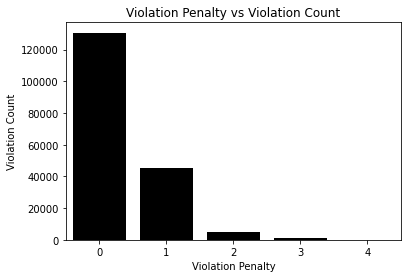

In [27]:
penalty_plot = sns.countplot(x="penalty", data=violations_df_clean, color="black")
penalty_plot.set_xlabel("Violation Penalty")
penalty_plot.set_ylabel("Violation Count")
penalty_plot.set_title("Violation Penalty vs Violation Count")
penalty_plot.set_xticks([0, 1, 2, 3 ,4], minor=False);

Text(0.5, 1.0, 'Violation Penalty')

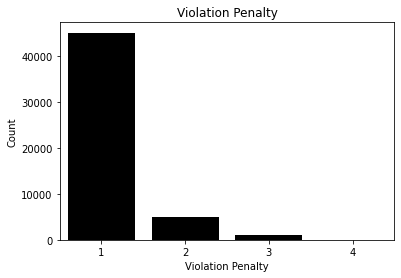

In [28]:
penalty_df = violations_df_clean[violations_df_clean["penalty"] >= 1]
penalty_plot = sns.countplot(x="penalty", data=penalty_df, color="black")
penalty_plot.set_xlabel("Violation Penalty")
penalty_plot.set_ylabel("Count")
penalty_plot.set_title("Violation Penalty")

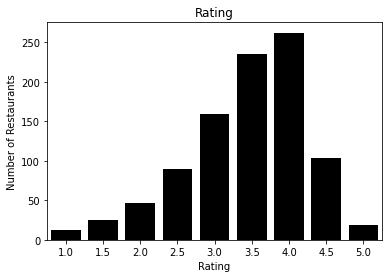

In [30]:
yelp_review_plot = sns.countplot(final_restaurant_df["rating"], color="black")
yelp_review_plot.set_xlabel("Rating")
yelp_review_plot.set_ylabel("Number of Restaurants")
yelp_review_plot.set_title("Rating")

yelp_review_plot;

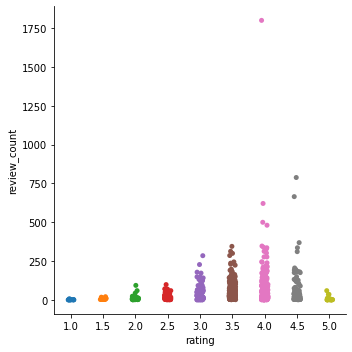

In [31]:
rating_review_count_plot = sns.catplot(x="rating", y="review_count", data=final_restaurant_df, linewidth=0)
#rating_review_count_plot.set_xlabel("Average Rating")
#rating_review_count_plot.set_ylabel("Number of Reviews");
#rating_review_count_plot.set_title("Average Rating");

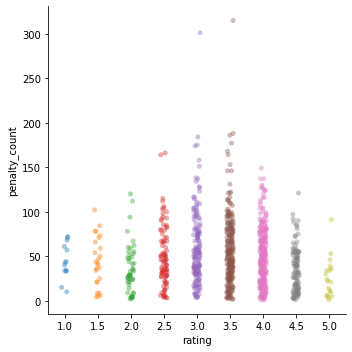

In [32]:
rating_review_count_plot = sns.catplot(x="rating", y="penalty_count", data=final_restaurant_df, linewidth=0, alpha=0.4)
#rating_review_count_plot.set_xlabel("Average Rating")
#rating_review_count_plot.set_ylabel("Number of Reviews");
#rating_review_count_plot.set_title("Average Rating");

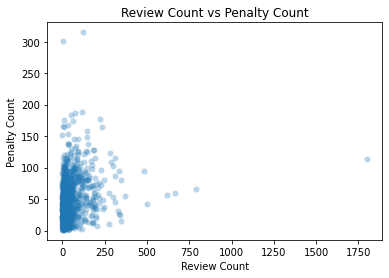

In [33]:
review_count_rating_plot = sns.scatterplot(x="review_count", y="penalty_count", data=final_restaurant_df, linewidth=0, alpha=0.3)
review_count_rating_plot.set_ylabel("Penalty Count");
review_count_rating_plot.set_xlabel("Review Count")
review_count_rating_plot.set_title("Review Count vs Penalty Count");

### Sentiment analysis on violation comment

In [34]:
violation_full_df = violations_df_clean.merge(final_restaurant_df, how="right", on="id")

# Remove entries without any comments
violation_full_df.dropna(how="any", subset=["comments", "rating", "review_count"], inplace=True)

In [35]:
violation_full_df = violation_full_df.sample(frac=1, random_state=200).reset_index(drop=True)
violation_full_df.head()

,id,inspect_date,comments,penalty,open_date,rating,review_count,penalty_count
0,4092016084,2013-07-09 00:00:00+00:00,4-903.11(A)&(B) Cross stack the dishes to allo...,1,2012-01-12 00:00:00+00:00,3.0,5.0,68
1,4092015424,2013-02-14 00:00:00+00:00,4-501.12 Cuttingboard on refrigerator with dar...,0,2009-06-24 00:00:00+00:00,3.0,92.0,60
2,4092016253,2015-03-16 00:00:00+00:00,3-301.11; Priority; Do NOT Touch Cheese Slices...,0,2012-09-25 00:00:00+00:00,3.0,79.0,87
3,4092017217,2016-05-19 00:00:00+00:00,3-304.14; Core; Store all wet wiping cloths in...,0,2016-04-28 00:00:00+00:00,4.0,36.0,22
4,4092016039,2016-03-30 00:00:00+00:00,7-203.11 ; Priority; Sanitizer was stored in a...,0,2011-11-02 00:00:00+00:00,3.0,12.0,48


In [36]:
num_training = int(0.8 * violation_full_df.shape[0])
num_test = int(0.2 * violation_full_df.shape[0])
num_validate = 0;

print("num_training: {}\nnum_test: {}\nnum_validate: {}".format(num_training, num_test, num_validate))

num_training: 38142
num_test: 9535
num_validate: 0


In [37]:
# Create vectorizer & specify parameters
tfidf = TfidfVectorizer(sublinear_tf=True, #apply sublinear TF scaling
                        analyzer='word',   #specify tokenizer
                        max_features=500, # specify max # of features to include
                        tokenizer=word_tokenize)

# Learn vocabulary and idf, return term-document matrix.
# return an array;our predictor
tfidf_X = tfidf.fit_transform(violation_full_df['comments']).toarray()

In [ ]:
#tfidf.get_feature_names()

In [ ]:
idf = tfidf.idf_
rr = dict(zip(tfidf.fit(violation_full_df['comments']).get_feature_names(), idf))

token_weight = pd.DataFrame.from_dict(rr, orient='index').reset_index()
token_weight.columns=('token','weight')
token_weight = token_weight.sort_values(by='weight', ascending=False)
token_weight.head() 

sns.barplot(x='token', 
            y='weight', 
            data=token_weight[0:10], 
            color="gray")            
plt.title("Inverse Document Frequency(IDF) per token")
fig = plt.gcf()
fig.set_size_inches(15,5);

In [ ]:
tfidf_Y = np.array(violation_full_df['penalty'])

In [ ]:
def train_SVM(X, Y, kernel='linear', class_weight=None):
    model = SVC(kernel=kernel, class_weight=class_weight)
    model.fit(X, Y)
    return model

In [ ]:
tfidf_train_x = tfidf_X[0:num_training]
tfidf_test_x = tfidf_X[num_training:]

tfidf_train_y = tfidf_Y[0:num_training]
tfidf_test_y = tfidf_Y[num_training:]

In [ ]:
svm_model_pure_tfidf = train_SVM(tfidf_train_x, tfidf_train_y, class_weight={
    4: 4,
    3: 3,
    2: 2,
    1: 1,
})

In [ ]:
df_predicted_tfidf_train_y = svm_model_pure_tfidf.predict(tfidf_train_x)
df_predicted_tfidf_test_y = svm_model_pure_tfidf.predict(tfidf_test_x)

In [ ]:
print(classification_report(tfidf_train_y, df_predicted_tfidf_train_y))